In [1]:
import wave
import numpy as np
import python_speech_features as ps
import os
import glob
import pickle
import librosa

In [2]:
# Defs

epsilon = 1e-5

def wgn(x, snr):
    snr = 10**(snr/10.0)
    xpower = np.sum(x**2)/len(x)
    npower = xpower / snr
    return np.random.randn(len(x)) * np.sqrt(npower)

def read_file(filename):
    file = wave.open(filename,'r')    
    params = file.getparams()
    nchannels, sampwidth, framerate, wav_length = params[:4]
    str_data = file.readframes(wav_length)
    wavedata = np.fromstring(str_data, dtype = np.short)
    # librosa.load(wav_file_path + orig_wav_file, sr=sr)
    time = np.arange(0,wav_length) * (1.0/framerate)
    file.close()
    return wavedata, time, framerate

def generate_label(control):
    label = 0
    if(control == 'cc'):
        label = 0
    elif(control == 'cd'):
        label = 1
    return label


In [3]:
# cd: 1358
# cc: 1476

epsilon = 1e-5

filter_num = 40

rootdir = 'train/Normalised_audio-chunks'

In [4]:
mean1,std1,mean2,std2,mean3,std3 = 0,1,0,1,0,1
ccnum = 1358 #0
cdnum = 1476 #1
# pernum = 300

In [5]:
# train_label = np.empty((train_num,1), dtype = np.int8)
# test_label = np.empty((test_num,1), dtype = np.int8)
# valid_label = np.empty((valid_num,1), dtype = np.int8)

# train_data = np.empty((train_num,300,filter_num,3),dtype = np.float32)
# test_data = np.empty((test_num,300,filter_num,3),dtype = np.float32)
# valid_data = np.empty((valid_num,300,filter_num,3),dtype = np.float32)

In [6]:
from scipy.io import wavfile
import librosa.display
import matplotlib.pyplot as plt

rootdir = 'train/Normalised_audio-chunks'
control = 'cc'
sub_dir = rootdir + '/' + control

for sample in os.listdir(sub_dir):
    data, rate = librosa.load(sub_dir+'/'+sample)
#     time = data.shape[0]
   
    sgram = librosa.stft(data)
    data = librosa.util.fix_length(data, size=8000, mode='symmetric')
    print ('Example shape ', data.shape, 'Sample rate ', rate, 'Data type', type(data))
    print (data)
    # use the mel-scale instead of raw frequency
    sgram_mag, _ = librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=rate)
    
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
    print(mel_sgram.shape)
#     librosa.display.specshow(mel_sgram, sr=rate, x_axis='time', y_axis='mel')
#     plt.colorbar(format='%+2.0f dB')
    
    break

Example shape  (8000,) Sample rate  22050 Data type <class 'numpy.ndarray'>
[-3.4325361e-01 -5.6174737e-01 -5.7129568e-01 ...  1.3424507e-04
  6.5730209e-04  1.2089183e-03]
(128, 15)


In [7]:
# max_duration = 0

# rootdir = 'train/Normalised_audio-chunks'
# for control in os.listdir(rootdir):

#     sub_dir = rootdir + '/' + control

#     for sample in os.listdir(sub_dir):
#         data, rate = librosa.load(sub_dir+'/'+sample)
#         length = data.shape[0]
#         if max_duration <= length:
#             max_duration = length
#         print(max_duration//rate)
            
            


In [8]:
# ----------------------------
# Prepare training data from Metadata file
# ----------------------------
import pandas as pd
# # from pathlib import Path

# download_path = Path.cwd()/'UrbanSound8K'

# Read metadata file
# metadata_file = download_path/'metadata'/'UrbanSound8K.csv'
# df = pd.read_csv(metadata_file)
# df.head()

# # Construct file path by concatenating fold and file name
# df['relative_path'] = '/fold' + df['fold'].astype(str) + '/' + df['slice_file_name'].astype(str)

# # Take relevant columns
# df = df[['relative_path', 'classID']]
# df.head()
rootdir = 'train/Normalised_audio-chunks'

data = []
for control in os.listdir(rootdir):
    Class = 0
    if control == 'cc':
        Class = 0
    else:
        Class = 1
        
    sub_dir = rootdir + '/' + control

    for sample in os.listdir(sub_dir):
        data.append([control + '/' + sample,Class])
#         print(sub_dir + '/' + sample,Class)
#         print(sample)

In [9]:
df = pd.DataFrame(data, columns = ['relative_path', 'classID'])
df.head()

,relative_path,classID
0,cc/S001-7-13310-20608-1-0-340.wav,0
1,cc/S001-7-13310-20608-2-2680-3630.wav,0
2,cc/S001-7-13310-20608-3-4160-4880.wav,0
3,cc/S001-7-13310-20608-4-6660-7300.wav,0
4,cc/S001-7-20608-27071-1-320-980.wav,0


In [10]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)
# ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))
# ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

 # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms
#     print(sig_len)
    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

# ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

# ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)
 # ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec


from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'classID']

    aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

In [11]:
from torch.utils.data import random_split

data_path = 'train/Normalised_audio-chunks/'
myds = SoundDS(df, data_path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])


# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images.to(CTX))                  # Generate predictions
        loss = F.cross_entropy(out, labels.to(torch.int64).cuda()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images.to(CTX))                    # Generate predictions
        loss = F.cross_entropy(out, labels.to(torch.int64).cuda())   # Calculate loss
        acc = accuracy(out, labels.to(torch.int64).cuda())           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
        

import torch
import math
import torch.nn as nn
import torch.nn.functional as F

# importing the libraries
import numpy as np

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
#         print(x.shape())
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out
    


* The audio from the file gets loaded into a Numpy array of shape (num_channels, num_samples). Most of the audio is sampled at 44.1kHz and is about 4 seconds in duration, resulting in 44,100 * 4 = 176,400 samples. If the audio has 1 channel, the shape of the array will be (1, 176,400). Similarly, audio of 4 seconds duration with 2 channels and sampled at 48kHz will have 192,000 samples and a shape of (2, 192,000).
* Since the channels and sampling rates of each audio are different, the next two transforms resample the audio to a standard 44.1kHz and to a standard 2 channels.
* Since some audio clips might be more or less than 4 seconds, we also standardize the audio duration to a fixed length of 4 seconds. Now arrays for all items have the same shape of (2, 176,400)
* The Time Shift data augmentation now randomly shifts each audio sample forward or backward. The shapes are unchanged.
* The augmented audio is now converted into a Mel Spectrogram, resulting in a shape of (num_channels, Mel freq_bands, time_steps) = (2, 64, 344)
* The SpecAugment data augmentation now randomly applies Time and Frequency Masks to the Mel Spectrograms. The shapes are unchanged.

In [13]:
class Att_Net(ImageClassificationBase):   
    def __init__(self):
        super(Att_Net, self).__init__()
        #The LW_CNN module utilizes three convolutions (C), two max-pooling
        # (MP), one average-pooling (AP), and one batch normalization
        # (BN) layer.
        self.LW_CNN = Sequential(
            # Defining a 2D convolution layer
#             Conv2d(300, 256, kernel_size=3, stride=1, padding=1),
#             BatchNorm2d(256),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=2, stride=2),
#             # Defining another 2D convolution layer
#             Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
#             BatchNorm2d(128),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=1, stride=1),
            
              #C1, we used 120 number of kernels with size (11
              # × 11) using (4 × 4) stride setting without padding to extract
              # initially hidden patterns from input data. 
              Conv2d(2, 120, kernel_size=(11,11), stride=(4,4), padding=0),
              MaxPool2d(kernel_size=(3,3), stride=None),
              Conv2d(120, 256, kernel_size=(5,5), stride=(1,1), padding='same'),
              MaxPool2d(kernel_size=(3,3)),
              Conv2d(256, 384, kernel_size=(3,3), padding='same'),
#               MaxPool2d(kernel_size=1, stride=0),
#               Conv2d(128, 1, kernel_size=(3,3), stride=(1,1), padding='same'),
              torch.nn.AvgPool2d(kernel_size=(1,1)),
              BatchNorm2d(384),
              ReLU(inplace=True),
        )

        self.linear_layers = Sequential(
            Linear(384 * 9 * 1, 256),
            Linear(256, 64),
            Linear(64, 2),
        )

        self.attention = CBAM(gate_channels=384)

    # Defining the forward pass    
    def forward(self, x):
#         x = x.view(-1, x.size(3),x.size(2),x.size(1))
#         print(x.size)
        x = self.LW_CNN(x)
        x = self.attention(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [14]:
# defining the model
model = Att_Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Att_Net(
  (LW_CNN): Sequential(
    (0): Conv2d(2, 120, kernel_size=(11, 11), stride=(4, 4))
    (1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(120, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): AvgPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0)
    (6): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=3456, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (attention): CBAM(
    (ChannelGate): ChannelGate(
      (mlp): Sequential(
        (0): Flatten()
        (1): Linear(in_features=384, out_features=24, bias=Tru

In [15]:
from torchsummary import summary
summary(model, (2, 64, 344))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 120, 14, 84]          29,160
         MaxPool2d-2           [-1, 120, 4, 28]               0
            Conv2d-3           [-1, 256, 4, 28]         768,256
         MaxPool2d-4            [-1, 256, 1, 9]               0
            Conv2d-5            [-1, 384, 1, 9]         885,120
         AvgPool2d-6            [-1, 384, 1, 9]               0
       BatchNorm2d-7            [-1, 384, 1, 9]             768
              ReLU-8            [-1, 384, 1, 9]               0
           Flatten-9                  [-1, 384]               0
           Linear-10                   [-1, 24]           9,240
             ReLU-11                   [-1, 24]               0
           Linear-12                  [-1, 384]           9,600
          Flatten-13                  [-1, 384]               0
           Linear-14                   

C:\Users\Asus\anaconda3\envs\tf-btp\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [17]:
# CTX = torch.device('cuda')
# train_dl.to(CTX)  #train_dataset.train_data is a Tensor(input data)
# # train_dl.train_labels.to(CTX)
# # val_dl.train_data.to(CTX)  #train_dataset.train_data is a Tensor(input data)
# # val_dl.train_labels.to(CTX)
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)




Epoch [0], train_loss: 0.7078, val_loss: 0.6922, val_acc: 0.5228
Epoch [1], train_loss: 0.6874, val_loss: 0.7117, val_acc: 0.4737
Epoch [2], train_loss: 0.6892, val_loss: 0.6914, val_acc: 0.5241
Epoch [3], train_loss: 0.6788, val_loss: 0.6956, val_acc: 0.5032
Epoch [4], train_loss: 0.6795, val_loss: 0.6961, val_acc: 0.5585
Epoch [5], train_loss: 0.6769, val_loss: 0.7210, val_acc: 0.5258
Epoch [6], train_loss: 0.6880, val_loss: 0.7079, val_acc: 0.4789
Epoch [7], train_loss: 0.6852, val_loss: 0.7028, val_acc: 0.5188
Epoch [8], train_loss: 0.6824, val_loss: 0.6939, val_acc: 0.5402
Epoch [9], train_loss: 0.6798, val_loss: 0.6874, val_acc: 0.5280
Epoch [10], train_loss: 0.6801, val_loss: 0.6763, val_acc: 0.5627
Epoch [11], train_loss: 0.6790, val_loss: 0.7080, val_acc: 0.5298
Epoch [12], train_loss: 0.6845, val_loss: 0.6946, val_acc: 0.4836
Epoch [13], train_loss: 0.6786, val_loss: 0.6902, val_acc: 0.5350
Epoch [14], train_loss: 0.6768, val_loss: 0.6938, val_acc: 0.5402
Epoch [15], train_lo

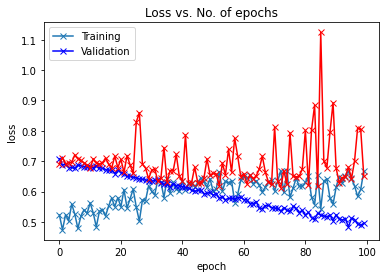

In [18]:
import matplotlib.pyplot as plt

def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)